In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from google.cloud.exceptions import GatewayTimeout
from google.api_core.exceptions import AlreadyExists, NotFound
from google.cloud import bigquery

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import logging

In [3]:
from logging.handlers import RotatingFileHandler

In [4]:
logging.basicConfig()

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
import logging

from logging.handlers import RotatingFileHandler
import sys

class IronLog:

    def __init__(self, logger_name = None, logfile : str = 'general.log', **kwargs):
        self.LOG_FILE = logfile

        self.FORMATTER = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(funcName)s - line: %(lineno)s - %(message)s",
                                          "%Y-%m-%d %H:%M:%S")
        
        self.logger = logging.getLogger(logger_name)
        self.logger.setLevel(logging.INFO)
        
        self.mb = kwargs.get('mb', 4)
        self.n_files = kwargs.get('n_files', 5)
        
        self.logger.handlers = []
        self.logger.addHandler(
            self._get_rotating_file_handler(self.mb, self.n_files)
        )

    def getLogger(self):
        return self.logger
        
    def _get_console_handler(self):
        """Return a simple stream handler to provide standard output."""
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(self.FORMATTER)
        return console_handler

    def _get_rotating_file_handler(self, mb, n_files):
        """
        Return a rotative log file handler. 
        It will create a file named `LOG_FILE` and as soon as the file starts to reach 
        the defined maxBytes, it will be renamed to LOG_FILE.1 up to LOG_FILE.n_files.
        The LOG_FILE.n_files is thrown to trash to give space for a new log file.
        
        So if you have mb = 4 MegaBytes and n_files = 5, the maximum space allowed would be 
        5 copies of 4MB each + the original log file --> 24 MB max.
        
        """
        file_handler = RotatingFileHandler(self.LOG_FILE, 
                                           maxBytes= mb * 1024**2, 
                                           backupCount=n_files)
        file_handler.setFormatter(self.FORMATTER)
        file_handler.setLevel(level=logging.DEBUG)
        return file_handler

In [22]:
from pandas import DataFrame
import re

from google.cloud import bigquery
from google.api_core.exceptions import AlreadyExists, NotFound, BadRequest

from functools import wraps


class IronSky:

    def __init__(self, dataset='ironhack_database'):
        self.client = bigquery.Client()
        self.dataset = dataset
        self.stats = IronStats(self, self.dataset)
        self.plot = IronPlot(self, self.dataset)
        
        return

    def tables(self, pattern=None, by_desc=None):
        """
        Return a dataframe containing the tables from the connected dataset.
        """
        # get list of dataset's tables and create the dataframe
        ds_list = self.client.list_tables(self.dataset)
        result = DataFrame(dict(
            table_name=[table.table_id for table in ds_list]
        ))
        
        # filter tables using regular expression
        if pattern:
            result = result.loc[result.table_name.str.contains(pattern)]

        return result

    def cost(self, sql, verbose=True):
        """
        Estimate the cost of a query in BigQuery considering each Gb costs $0.02 cents.
        """
        logger = IronLog('bq').getLogger()
        
        job_config = bigquery.QueryJobConfig()
        job_config.dry_run = True
        job_config.use_query_cache = False
        
        try:
            job = self.client.query(sql, location='US', job_config=job_config)
        except BadRequest as error:
            "Check if the person forgot to put the dataset name (dataset.table_name)"
            msg = error.message
            # log the error message and say what you're trying to do.
            logger.warning(msg)
            logger.warning('Trying to correct the mistake by inputing the dataset name.')

            if re.findall('(missing dataset)', msg):
                tentative_sql = re.sub('(FROM +)' , f'FROM {self.dataset}.', sql)
                logger.info('Running the following query:')
                logger.info(tentative_sql)
                job = self.client.query(tentative_sql, location='US', job_config=job_config)
            
        mb = job.total_bytes_processed / 1024**2

        # 0.02 cents for each GB processed.
        dollar = (job.total_bytes_processed / 1024**3) * 0.02

        if verbose:
            logger.info(f'Processing {mb:2,.0f} MB, which costs US$ {dollar:,.2f}')
            
        return dollar

    def head(self, table, nrows=5):
        """
        Fetch the table from BigQuery and show the top nrows
        in a dataframe format."""
        table = self.client.get_table(table)
        return self.client.list_rows(table, max_results=nrows).to_dataframe()

    def partitions(self, table):
        "Return the ids of the partitions of a table."
        table = self.client.get_table(table)
        return self.client.list_partitions(table)


    def query(self, sql, verbose=True):
        """
        Send a query to bigquery and return the result as a dataframe.
        
        Estimate the cost of the query
        """
        job = self.client.query(sql)
        result = job.result().to_dataframe()
        
        if verbose and job.total_bytes_billed is not None:
            mb = job.total_bytes_billed / 1024**2
            dollar = job.total_bytes_billed / 1024**3 * 0.02
            logger = IronLog('bq').getLogger()
            logger.info(f'Processing {mb:2,.0f} MB, which costs US$ {dollar:,.2f}')
            
        return result

    def download(self, table):
        """
        Download the table to a dataframe.
        """
        table = self.client.get_table(table)
        return self.client.list_rows(table).to_dataframe()

    def upload(self, data : DataFrame, table_name : str, overwrite=False):
        """
        Upload a dataframe to the bigquery dataset.
        """
        logger = IronLog('bq').getLogger()

        if overwrite:
            tables = self.client.tables()
        
        try:
            self.client.load_table_from_dataframe(data, table_name)
        except ValueError as error:
            """ 
            ValueError is usually the case when the user forgot to specify the
            `dataset.` prefix.
            
            The fix here is to try to infer the dataset and input into as the
            prefix of the table_name (as `dataset.table_name`)
            """
            logger.warning(error.args[0])
            if re.findall('(project.dataset.table_id)', error.args[0]):
                logger.warning('Infering the dataset and repeating the action.')
                self.client.load_table_from_dataframe(data, f'{self.dataset}.' + table_name)
        
        logger.info(f'{table_name} uploaded.')

        return


In [379]:
class IronPlot:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    def __init__(self, client, dataset):
        self.client = client
        self.dataset = dataset
        
    def cum_freq(self, table_name, col_name : Union[str, List], verbose=True):
        data = self.client.stats.freq(table_name, col_name).data
        selected_cols = [col for col in data.columns if col.startswith('qt')]
        return data


In [380]:
X = pd.DataFrame().style

In [381]:
class IronStyle:
    
    def __init__(self, dataframe : DataFrame, 
                       bg_color : Union[None, str] = 'green', 
                       highlight : Union[None, str] = None, 
                       caption : Union[None, str] = None, 
                       selected_cols : Union[List[str], List] = []):
        """
        Gets a dataframe and apply some layout.
        
        bg_color : Either None (which means no background color should be selected) 
                   or a colormap. The list of colormaps can be found using `plt.colormaps()`
        highlight: Either None (which means no highligh will be done) or a string representing 
                   a color, for example 'red' or 'yellow'
        caption:   Either None (which means the dataframe will not be captioned) or the string
                   you want above the representation of the dataframe
                   
        """
        self.dataframe = dataframe
        self.bg_color = bg_color
        self.highlight = highlight
        self.caption = caption
        self.selected_cols = selected_cols
                
    def apply_style(self):
        """
        Return a styler dataframe with the desired styling. 
        
        For the current implementation, apply_style performs background_gradient 
        and highlight for some specific columns via the argument `selected_cols` 
        or, if no column is specified, color the columns that starts with `qt` or `vl`.
        """
        styler = self.dataframe.style
        if not self.selected_cols: 
            self.selected_cols = [col for col in self.dataframe.columns 
                                  if col.startswith('qt') or col.startswith('vl')]

        print(self.selected_cols)
        if self.bg_color:
            cm = sns.light_palette(self.bg_color, as_cmap=True)
            styler = styler.background_gradient(cmap=cm, subset=self.selected_cols)
        if self.highlight:
            styler = styler.highlight_max(subset=self.selected_cols, color =self.highlight)
        if self.caption:
            styler = styler.set_caption(self.caption)
            
        return styler
            
    def _plot_all_cmaps(self):
        import matplotlib as mpl
        import matplotlib.pyplot as plt

        def plot_cmaps(cmap):

            fig, ax = plt.subplots(figsize=(4,0.4))
            col_map = plt.get_cmap(cmap)
            mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

            plt.show()

        for cmap_id in plt.colormaps():
            print(cmap_id)
            plot_cmaps(cmap_id)

    def _plot_specific_cmap(self, cmap):
        import matplotlib as mpl
        import matplotlib.pyplot as plt

        def plot_cmaps(cmap):

            fig, ax = plt.subplots(figsize=(4,0.4))
            col_map = plt.get_cmap(cmap)
            mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

            plt.show()
            
        print(cmap)
        plot_cmaps(cmap)

    

['perc_survived', 'perc_pclass']

In [411]:
from typing import List, Union
from IPython.display import display, Markdown

class IronStats:
    
    def __init__(self, client, dataset):
        self.client = client
        self.dataset = dataset
    
    def freq(self, 
             table_name, 
             col_name : Union[str, List], 
             verbose=True, 
             order_by_freq=False, 
             ascending=True):
        """
        Return a dataframe (styler) containing the frequency table of the `col_name` 
        (which can be a list of columns) specified.
        """
        if not isinstance(col_name, list) or not isinstance(col_name,tuple):
            col_name = list(col_name)
        
        query_str = self._freq_query(table_name, col_name,verbose)
        cols_str = ' and '.join(col_name)
        caption = f'''Frequency table for {table_name}<br>Grouped by {cols_str}'''
        
        """
                    keys = ', \n\t\t'.join(col_name)
                    counts = [f'COUNT({col}) AS qtd_{col.lower()}' for col in col_name]
                    cols_str = ' and '.join(col_name)
                    caption = f'''Frequency table for {table_name}<br>Grouped by {cols_str}'''
                    aggregations = ',\n\t\t'.join(counts)
                    query_str = f'''
         SELECT {keys},
                {aggregations}
           FROM {self.dataset}.{table_name}
          GROUP BY {keys}
        '''
        """      
            
        if verbose:
            display(Markdown(f'''```sql {query_str}```'''))
        
        if order_by_freq:
            freq_cols = [col.replace('qtd','perc') for col in col_name]
            print(freq_cols)
            result = self.client.query(query_str).sort_values(by=freq_cols, 
                                                              ascending=ascending)
        else:
            result = self.client.query(query_str).sort_values(by=col_name, 
                                                              ascending=ascending)
        
        return IronStyle(result, caption=caption).apply_style()
        
        
    def _freq_query(self, table_name, col_name, verbose):
        keys = col_name
        counts = [f'''COUNT({col_name}) AS qtd_{col_name.lower()},\n
                      COUNT({col_name})/(SUM(COUNT(*)) OVER()) AS perc_{col_name.lower()}'''
                 for col in col_name]
        caption = f'''Frequency table for {table_name}<br>Grouped by {col_name}'''
        aggregations = ',\n\t\t'.join(counts)
        query_str = (f'''
                     SELECT {keys},
                            {aggregations}
                       FROM {self.dataset}.{table_name}
                      GROUP BY {keys}
                    ''')
        
        return query_str

# Instantiating the client

In [412]:
bq = IronSky()

In [413]:
bq.stats.freq('titanic','Survived')

AttributeError: 'list' object has no attribute 'lower'

In [406]:
bq.stats.freq('titanic','Survived', order_by_freq=True)

```sql 
                     SELECT Survived,
                            COUNT(Survived) AS qtd_survived,

                      COUNT(Survived)/(SUM(COUNT(*)) OVER()) AS perc_survived
                       FROM ironhack_database.titanic
                      GROUP BY Survived
                    ```

INFO:bq:Processing  0 MB, which costs US$ 0.00


KeyError: 'S'

## Plot.cum_freq

In [361]:
bq.plot.cum_freq('titanic','Survived', order_by_freq=False, )

```sql 
 SELECT Survived,
        COUNT(Survived) AS qtd_survived
   FROM ironhack_database.titanic
  GROUP BY Survived
```

INFO:bq:Processing  0 MB, which costs US$ 0.00


['qtd_survived']


,Survived,qtd_survived
1,0,1272
0,1,864


In [362]:
df = Out[361]

In [363]:
df.sort_values(by='qtd_survived')

,Survived,qtd_survived
0,1,864
1,0,1272


In [364]:
pd.concat([pd.DataFrame([0]), df.sort_values(by='qtd_survived')['qtd_survived']]).reset_index(drop=True)

,0
0,0
1,864
2,1272


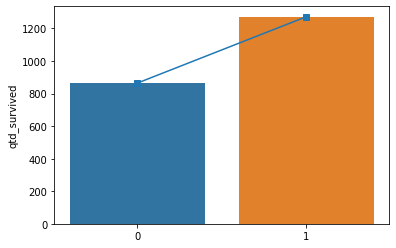

In [365]:
sns.barplot(x=[0,1], y=df.sort_values(by='qtd_survived')['qtd_survived'])
plt.plot([0,1], df.sort_values(by='qtd_survived')['qtd_survived'], '-s')

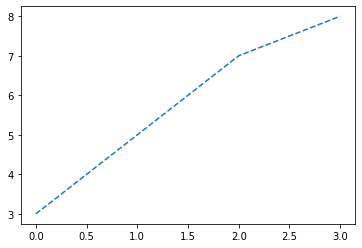

In [349]:

plt.plot([0,1,2,3],[3,5,7,8], '--')

# Stats.freq

In [307]:
bq.stats.freq('titanic', 'Survived', )

```sql 
 SELECT Survived,
        COUNT(Survived) AS qtd_survived
   FROM ironhack_database.titanic
  GROUP BY Survived
```

INFO:bq:Processing  0 MB, which costs US$ 0.00


['qtd_survived']


,Survived,qtd_survived
1,0,1272
0,1,864


In [308]:
bq.stats.freq('titanic', ['Survived'])

```sql 
 SELECT Survived,
        COUNT(Survived) AS qtd_survived
   FROM ironhack_database.titanic
  GROUP BY Survived
```

INFO:bq:Processing  0 MB, which costs US$ 0.00


['qtd_survived']


,Survived,qtd_survived
1,0,1272
0,1,864


In [309]:
bq.stats.freq('titanic', ['Survived', 'Pclass'])

```sql 
 SELECT Survived, 
		Pclass,
        COUNT(Survived) AS qtd_survived,
		COUNT(Pclass) AS qtd_pclass
   FROM ironhack_database.titanic
  GROUP BY Survived, 
		Pclass
```

INFO:bq:Processing  0 MB, which costs US$ 0.00


['qtd_survived', 'qtd_pclass']


,Survived,Pclass,qtd_survived,qtd_pclass
3,0,1,192,192
5,0,2,270,270
1,0,3,810,810
4,1,1,360,360
0,1,2,249,249
2,1,3,255,255


In [310]:
client.query('SELECT * FROM ironhack_database.titanic')

# Listing tables of dataset

In [9]:
client.tables()

,table_name
0,titanic
1,titanic_v2


In [10]:
client.tables(pattern='.*c')

,table_name
0,titanic
1,titanic_v2


# Estimating costs of queries

In [11]:
sql = '''SELECT * FROM ironhack_database.titanic'''
client.cost(sql)

INFO:bq:Processing  0 MB, which costs US$ 0.00


3.1828880310058593e-06

> If you forget the `ironhack_database` dataset name, it tries to figure it out for you and retry.

In [12]:
sql = 'SELECT * FROM titanic'
client.cost(sql)


(job ID: 1224126a-8299-4fb8-b09c-92420ea2e2df)

-----Query Job SQL Follows-----

    |    .    |    .    |
   1:SELECT * FROM titanic
    |    .    |    .    |
INFO:bq:Running the following query:
INFO:bq:SELECT * FROM ironhack_database.titanic
INFO:bq:Processing  0 MB, which costs US$ 0.00


3.1828880310058593e-06

# Upload table to BigQuery

In [13]:
import pandas as pd
titanic = pd.read_csv('../../ironhack-analytics/pca/titanic_processed.csv')

In [14]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,3,0,38.0,1,5,31.3875,0,0,1
1,0,1,1,40.0,0,0,27.7208,1,0,0
2,0,3,1,26.0,0,0,7.8875,0,0,1
3,1,1,0,30.0,0,0,106.4250,1,0,0
4,0,2,1,16.0,0,0,10.5000,0,0,1


In [15]:
client.upload(titanic, f'titanic_v2');

INFO:bq:titanic_v2 uploaded.


# Download 

In [16]:
client.download('ironhack_database.titanic')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,2,1,2.00,1,1,26.0000,0,0,1
1,1,2,0,2.00,1,1,26.0000,0,0,1
2,1,2,1,2.00,1,1,26.0000,0,0,1
3,1,2,0,2.00,1,1,26.0000,0,0,1
4,1,2,1,2.00,1,1,26.0000,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2131,1,2,1,0.83,1,1,18.7500,0,0,1
2132,1,2,1,0.83,1,1,18.7500,0,0,1
2133,1,3,1,0.42,0,1,8.5167,1,0,0
2134,1,3,1,0.42,0,1,8.5167,1,0,0


## Download specific columns

## Download partition

## Download to csv

# Query

In [17]:
client.query('select Age, Survived from ironhack_database.titanic')

INFO:bq:Processing 10 MB, which costs US$ 0.00


,Age,Survived
0,2.00,1
1,2.00,1
2,2.00,1
3,2.00,1
4,2.00,1
...,...,...
2131,0.83,1
2132,0.83,1
2133,0.42,1
2134,0.42,1


# Plot module

In [18]:
client.plot.freq('titanic', 'Survived')

AttributeError: 'IronSky' object has no attribute 'plot'

In [ ]:
client.query('select * from ironhack_database.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS')

In [ ]:
table.schema

In [ ]:
job_config = bigquery.LoadJobConfig()

In [ ]:
job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND

In [ ]:
job_config.schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION]

In [ ]:
y = table.schema[0]

In [ ]:
job_config.schema